Import necessary libraries

In [15]:
'''
#Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


Load data and set the parameters

In [16]:
batch_size = 512
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10__model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
#normalized the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Generate the CNN model

In [25]:
def cnn():
  modelcnn = Sequential()
  modelcnn.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
  modelcnn.add(Activation('relu'))
  modelcnn.add(Conv2D(32, (3, 3)))
  modelcnn.add(Activation('relu'))
  modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
  modelcnn.add(Dropout(0.25))

  modelcnn.add(Conv2D(64, (3, 3), padding='same'))
  modelcnn.add(Activation('relu'))
  modelcnn.add(Conv2D(64, (3, 3)))
  modelcnn.add(Activation('relu'))
  modelcnn.add(MaxPooling2D(pool_size=(2, 2)))
  modelcnn.add(Dropout(0.25))

  modelcnn.add(Flatten())
  modelcnn.add(Dense(512))
  modelcnn.add(Activation('relu'))
  modelcnn.add(Dropout(0.5))
  modelcnn.add(Dense(num_classes))
  modelcnn.add(Activation('softmax'))

  return modelcnn


Define the Neural Network model

In [26]:
def nn(hidden_layers=0):
  modelnn = Sequential()
  #modelnn.add(Flatten(input_shape=x_train.shape[1:]))
  modelnn.add(Flatten())

  for layer in range(hidden_layers):
    modelnn.add(Dense(512))
    modelnn.add(Activation('relu'))
    modelnn.add(Dropout(0.5))

  modelnn.add(Dense(num_classes))
  modelnn.add(Activation('softmax'))

  return modelnn

#obtain the 0, 1, 2, 3, 4 hidden layers
for hidden_layers in [0, 1, 2, 3, 4]:
  modelnn = nn(hidden_layers)

In [27]:
models={'cnn': cnn(),
    '0_h_layer': nn(0),
    '1_h_layer': nn(1),
    '2_h_layer': nn(2),
    '3_h_layer': nn(3),
    '4_h_layer': nn(4)}

Train the model

In [36]:
histories={}
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
for name, model in models.items():
  print(f"Training model: {name}")
  model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=True)

  else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
      featurewise_center=False, # set input mean to 0 over the dataset
      samplewise_center=False, # set each sample mean to 0
      featurewise_std_normalization=False, # divide inputs by std of the dataset
      samplewise_std_normalization=False, # divide each input by its std
      zca_whitening=False, # apply ZCA whitening
      zca_epsilon=1e-06, # epsilon for ZCA whitening
      rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
      # randomly shift images horizontally (fraction of total width)
      width_shift_range=0.1,
      # randomly shift images vertically (fraction of total height)
      height_shift_range=0.1,
      shear_range=0., # set range for random shear
      zoom_range=0., # set range for random zoom
      channel_shift_range=0., # set range for random channel shifts
      # set mode for filling points outside the input boundaries
      fill_mode='nearest',
      cval=0., # value used for fill_mode = "constant"
      horizontal_flip=True, # randomly flip images
      vertical_flip=False, # randomly flip images
      # set rescaling factor (applied before any other transformation)
      rescale=None,
      # set function that will be applied on each input
      preprocessing_function=None,
      # image data format, either "channels_first" or "channels_last"
      data_format=None,
      # fraction of images reserved for validation (strictly between 0 and 1)
      validation_split=0.0)
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),epochs=epochs,
                        validation_data=(x_test, y_test),workers=4)
  histories[name]=history


Training model: cnn
Using real-time data augmentation.


<ipython-input-36-05e583dbc407>:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),epochs=epochs,


Epoch 1/10
98/98 [==============================] - 38s 366ms/step - loss: 2.1042 - accuracy: 0.2148 - val_loss: 1.9726 - val_accuracy: 0.2766
Epoch 2/10
98/98 [==============================] - 37s 367ms/step - loss: 1.9142 - accuracy: 0.3025 - val_loss: 1.7855 - val_accuracy: 0.3821
Epoch 3/10
98/98 [==============================] - 36s 353ms/step - loss: 1.8137 - accuracy: 0.3414 - val_loss: 1.7188 - val_accuracy: 0.3869
Epoch 4/10
98/98 [==============================] - 36s 357ms/step - loss: 1.7489 - accuracy: 0.3634 - val_loss: 1.6469 - val_accuracy: 0.4102
Epoch 5/10
98/98 [==============================] - 39s 380ms/step - loss: 1.7051 - accuracy: 0.3798 - val_loss: 1.6598 - val_accuracy: 0.4055
Epoch 6/10
98/98 [==============================] - 36s 353ms/step - loss: 1.6643 - accuracy: 0.3945 - val_loss: 1.5754 - val_accuracy: 0.4260
Epoch 7/10
98/98 [==============================] - 39s 380ms/step - loss: 1.6273 - accuracy: 0.4067 - val_loss: 1.5602 - val_accuracy: 0.4420

Save model and weights

In [37]:
for name, model in models.items():
  if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)

    model.save(model_path)
    print(f'Saved {name} model at %s ' % model_path)


Score trained model.

In [38]:
for name, model in models.items():
  scores = model.evaluate(x_test, y_test, verbose=1)
  print(f'{name} Test loss:', scores[0])
  print(f'{name} Test accuracy:', scores[1])


313/313 [==============================] - 1s 3ms/step - loss: 1.3938 - accuracy: 0.4975
cnn Test loss: 1.3937783241271973
cnn Test accuracy: 0.4975000023841858
313/313 [==============================] - 1s 3ms/step - loss: 1.8293 - accuracy: 0.3630
0_h_layer Test loss: 1.8292995691299438
0_h_layer Test accuracy: 0.3630000054836273
313/313 [==============================] - 1s 3ms/step - loss: 1.6470 - accuracy: 0.4321
1_h_layer Test loss: 1.647033929824829
1_h_layer Test accuracy: 0.43209999799728394
313/313 [==============================] - 1s 3ms/step - loss: 1.6309 - accuracy: 0.4278
2_h_layer Test loss: 1.6308945417404175
2_h_layer Test accuracy: 0.4277999997138977
313/313 [==============================] - 1s 3ms/step - loss: 1.6724 - accuracy: 0.4189
3_h_layer Test loss: 1.6723867654800415
3_h_layer Test accuracy: 0.4189000129699707
313/313 [==============================] - 1s 3ms/step - loss: 1.6312 - accuracy: 0.4314
4_h_layer Test loss: 1.631156086921692
4_h_layer Test accu

Plot the curves

In [35]:
import matplotlib.pyplot as plt

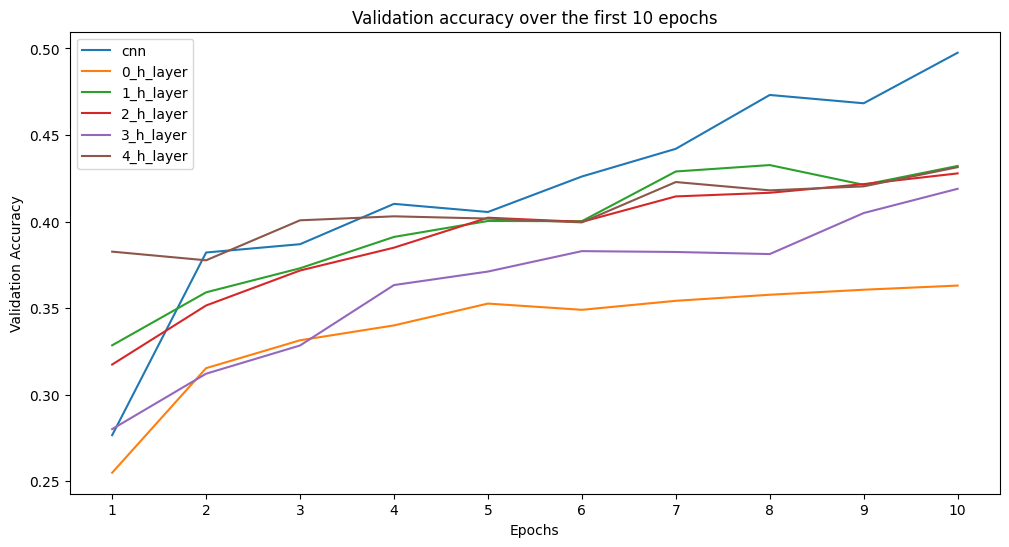

In [42]:
plt.figure(figsize=(12, 6))

for name, history in histories.items():
    plt.plot(range(1,11),history.history['val_accuracy'][:10], label=name)

plt.title('Validation accuracy over the first 10 epochs')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(list(range(1,11)))
plt.legend()
plt.show()

Observation:
<br>(1)Generally, the CNN model has higher accuracy than the neural network model.
<br>(2)Also, as the hidden layers of neural network increase, the accuracy of the neural network would increase.
<br>(3)However, it is possible for the neural network with more hidden layers to have a lower accuracy.

Explanation: <br>(1)As for Convolutional Neural Network, it is more effective when it learns the special hierarchical features in the image classifications, even some complicated features, and it could also recognize the patterns no matter where the image is. So that it might have a better performances than the dense simple neural network.
<br>(2)When the number of hidden layers increases, the capacity of network increases, and might fit more complicated functions, so that it might have better performances when the hidden layers increase.
<br>(3)However, it is possible to have overfitting in the testing data(the training data might fit the model)as there are a lot of hidden layers. At that time, the neural network might have a lower accuracy and worse performance.   

Question(B)

In [43]:
def sigmoidcnn(): #sigmoid cnn
  modelcnn2 = Sequential()
  modelcnn2.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
  modelcnn2.add(Activation('sigmoid'))
  modelcnn2.add(Conv2D(32, (3, 3)))
  modelcnn2.add(Activation('sigmoid'))
  modelcnn2.add(MaxPooling2D(pool_size=(2, 2)))
  modelcnn2.add(Dropout(0.25))

  modelcnn2.add(Conv2D(64, (3, 3), padding='same'))
  modelcnn2.add(Activation('sigmoid'))
  modelcnn2.add(Conv2D(64, (3, 3)))
  modelcnn2.add(Activation('sigmoid'))
  modelcnn2.add(MaxPooling2D(pool_size=(2, 2)))
  modelcnn2.add(Dropout(0.25))

  modelcnn2.add(Flatten())
  modelcnn2.add(Dense(512))
  modelcnn2.add(Activation('sigmoid'))
  modelcnn2.add(Dropout(0.5))
  modelcnn2.add(Dense(num_classes))
  modelcnn2.add(Activation('softmax'))

  return modelcnn2

In [44]:
models2={'cnn': cnn(),
    'sigmoidcnn': sigmoidcnn()}

In [45]:
histories2={}
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
for name, model in models2.items():
  print(f"Training model: {name}")
  model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

  if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=True)

  else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
      featurewise_center=False, # set input mean to 0 over the dataset
      samplewise_center=False, # set each sample mean to 0
      featurewise_std_normalization=False, # divide inputs by std of the dataset
      samplewise_std_normalization=False, # divide each input by its std
      zca_whitening=False, # apply ZCA whitening
      zca_epsilon=1e-06, # epsilon for ZCA whitening
      rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
      # randomly shift images horizontally (fraction of total width)
      width_shift_range=0.1,
      # randomly shift images vertically (fraction of total height)
      height_shift_range=0.1,
      shear_range=0., # set range for random shear
      zoom_range=0., # set range for random zoom
      channel_shift_range=0., # set range for random channel shifts
      # set mode for filling points outside the input boundaries
      fill_mode='nearest',
      cval=0., # value used for fill_mode = "constant"
      horizontal_flip=True, # randomly flip images
      vertical_flip=False, # randomly flip images
      # set rescaling factor (applied before any other transformation)
      rescale=None,
      # set function that will be applied on each input
      preprocessing_function=None,
      # image data format, either "channels_first" or "channels_last"
      data_format=None,
      # fraction of images reserved for validation (strictly between 0 and 1)
      validation_split=0.0)
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),epochs=epochs,
                        validation_data=(x_test, y_test),workers=4)
  histories2[name]=history

Training model: cnn
Using real-time data augmentation.


<ipython-input-45-1c6adcbd358b>:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),epochs=epochs,


Epoch 1/10
98/98 [==============================] - 36s 349ms/step - loss: 2.0823 - accuracy: 0.2326 - val_loss: 1.8640 - val_accuracy: 0.3544
Epoch 2/10
98/98 [==============================] - 35s 344ms/step - loss: 1.8734 - accuracy: 0.3208 - val_loss: 1.7332 - val_accuracy: 0.3907
Epoch 3/10
98/98 [==============================] - 35s 344ms/step - loss: 1.7933 - accuracy: 0.3514 - val_loss: 1.6909 - val_accuracy: 0.3952
Epoch 4/10
98/98 [==============================] - 33s 323ms/step - loss: 1.7395 - accuracy: 0.3677 - val_loss: 1.6477 - val_accuracy: 0.4083
Epoch 5/10
98/98 [==============================] - 34s 324ms/step - loss: 1.7005 - accuracy: 0.3811 - val_loss: 1.6150 - val_accuracy: 0.4199
Epoch 6/10
98/98 [==============================] - 34s 331ms/step - loss: 1.6655 - accuracy: 0.3943 - val_loss: 1.5218 - val_accuracy: 0.4538
Epoch 7/10
98/98 [==============================] - 38s 377ms/step - loss: 1.6287 - accuracy: 0.4084 - val_loss: 1.5066 - val_accuracy: 0.4543

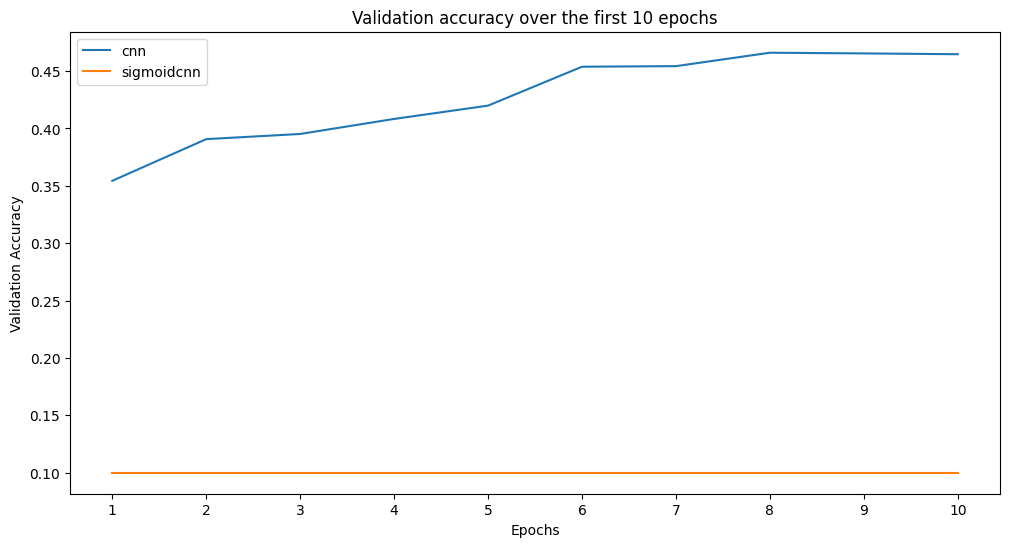

In [46]:
plt.figure(figsize=(12, 6))

for name, history in histories2.items():
    plt.plot(range(1,11),history.history['val_accuracy'][:10], label=name)
    #plt.plot(history.history['val_accuracy'], label=name)  # We use `:10` to limit it to the first 10 epochs

plt.title('Validation accuracy over the first 10 epochs')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epochs')
plt.xticks(list(range(1,11)))  # Ensure x-axis labels align with 10 epochs
plt.legend()
plt.show()

Observation:
<br>The sigmoid function has much worse performance and lower test accuracy than the Relu function.

Explanation:
<br>Due to the characteristic of the sigmoid function, it limites the output range from 0 to 1, so that it easily comes to the vanishing gradient problem, and it is difficult to train the model with a pretty small weights. Therefore, Relu does not have the problem and has a better performance than the sigmoid activation  function.


Question(C)

In [47]:
def cnn2(use_dropout=True):
    modelcnn2 = Sequential()
    modelcnn2.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    modelcnn2.add(Activation('relu'))
    modelcnn2.add(Conv2D(32, (3, 3)))
    modelcnn2.add(Activation('relu'))
    modelcnn2.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        modelcnn2.add(Dropout(0.25))

    modelcnn2.add(Conv2D(64, (3, 3), padding='same'))
    modelcnn2.add(Activation('relu'))
    modelcnn2.add(Conv2D(64, (3, 3)))
    modelcnn2.add(Activation('relu'))
    modelcnn2.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        modelcnn2.add(Dropout(0.25))

    modelcnn2.add(Flatten())
    modelcnn2.add(Dense(512))
    modelcnn2.add(Activation('relu'))
    if use_dropout:
        modelcnn2.add(Dropout(0.5))
    modelcnn2.add(Dense(num_classes))
    modelcnn2.add(Activation('softmax'))

    return modelcnn2

In [50]:
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)
epochs = 25

configurations = [
    {"use_dropout": True, "data_augmentation": True},
    {"use_dropout": False, "data_augmentation": True},
    {"use_dropout": True, "data_augmentation": False},
    {"use_dropout": False, "data_augmentation": False},
]

history_records = {}

for config in configurations:
    model = cnn2(use_dropout=config["use_dropout"])
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    if config["data_augmentation"]:
        datagen.fit(x_train)
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                      epochs=epochs, validation_data=(x_test, y_test), workers=4)
    else:
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_test, y_test), shuffle=True)

    config_name = f"Dropout_{'On' if config['use_dropout'] else 'Off'}_DataAug_{'On' if config['data_augmentation'] else 'Off'}"
    history_records[config_name] = history

<ipython-input-50-e47328c1d4fb>:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


Epoch 1/25
98/98 [==============================] - 38s 373ms/step - loss: 2.1420 - accuracy: 0.1999 - val_loss: 1.9763 - val_accuracy: 0.2977
Epoch 2/25
98/98 [==============================] - 37s 357ms/step - loss: 1.9372 - accuracy: 0.2944 - val_loss: 1.7856 - val_accuracy: 0.3783
Epoch 3/25
98/98 [==============================] - 37s 351ms/step - loss: 1.8220 - accuracy: 0.3376 - val_loss: 1.8376 - val_accuracy: 0.3417
Epoch 4/25
98/98 [==============================] - 35s 349ms/step - loss: 1.7579 - accuracy: 0.3598 - val_loss: 1.6564 - val_accuracy: 0.4070
Epoch 5/25
98/98 [==============================] - 39s 378ms/step - loss: 1.7114 - accuracy: 0.3777 - val_loss: 1.6045 - val_accuracy: 0.4189
Epoch 6/25
98/98 [==============================] - 35s 352ms/step - loss: 1.6725 - accuracy: 0.3904 - val_loss: 1.5856 - val_accuracy: 0.4211
Epoch 7/25
98/98 [==============================] - 36s 355ms/step - loss: 1.6377 - accuracy: 0.4015 - val_loss: 1.5347 - val_accuracy: 0.4440

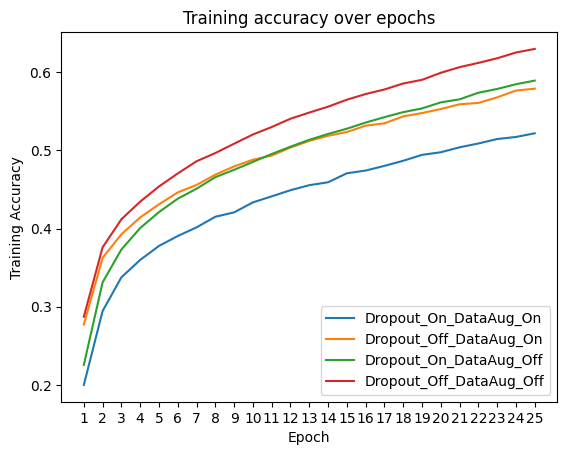

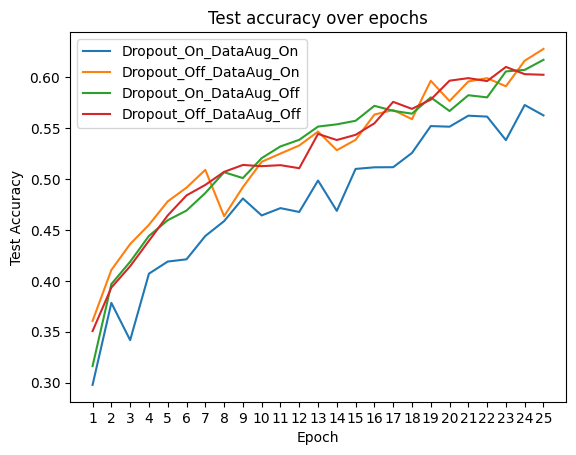

In [53]:
import matplotlib.pyplot as plt

# Plot training accuracy
for config_name, history in history_records.items():
    plt.plot(range(1,26),history.history['accuracy'], label=config_name)

plt.title('Training accuracy over epochs')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.xticks(list(range(1,26)))
plt.legend()
plt.show()

# Plot test/validation accuracy
for config_name, history in history_records.items():
    plt.plot(range(1,26),history.history['val_accuracy'], label=config_name)

plt.title('Test accuracy over epochs')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.xticks(list(range(1,26)))
plt.legend()
plt.show()

Observation:
<br>(1)In the training set, the plot has been shown as my prediction(the results ARE consistent with the theory).
<br>The dropout_on_dataaug_on team has the lowest accuracy and worst performance, and the drop_off_dataaug_off team has the highest accuracy and best performance.
<br>I only set the epoch as 25, and I think it would have the same trend if the epoch is 100.Right now the accuracy is more than 0.6(best performance team), and increases as the epoch increases. And it might be a bit more than 0.7(best team) when the epoch is 100.
<br><br>(2)In the test set,the plot has not shown as my prediction, (the results are NOT consistent with the theory).
<br>It shows that the dropout_on_dataaug_on team still has the lowest accuracy and worst performance, while the rest three teams look similar, and we can not say which team has better performance.
<br>Also, the current epoch is 25, and it might have the same trend if the epoch is 100. And the highest accuracy of test set might come to 0.7 when the epoch is 100.

Explanation:
<br>(1)For training set, it is easy to explain, because the results are consitent with the theory. <br>The Drop_off_Dataaug_off team model will have the all its neurons, and nothing would be thrown or changed. They use the same data to train, so that it has the best performance.
<br>As for only drop off set, there are some data missing, and it will decrease the accuracy.
<br>As for only data augmentation team, the augmentation makes the training get more difficult, decreasing the accuracy.
<br>As for drop_on_dataaug_on team, the performance would be the worst, as it changes the data from two ways.
<br><br>
(2)For test set, the resulta are NOT consitent with the theory, and as the theory, it should be that drop_on_dataaug_on team had the best performance. (If so, it could be cause by the combination of drop and augmentation, which could help to avoid overfitting and do regularization, generalizing the model better.)
<br>HOWEVER, the double_on team still has the worst performance similar to training set compared with other three teams. The the double_off team has the best performance.
It might be caused by the characteristic of the dataset, which might not complex, so that it might not cause much overfitting. So that it might be not help to use the dropout or data augmentation.
<br>Similariy, the CIFAR-10 dataset is relatively diverse, so that we might not do much data augmentation.